
Found 141 files in the folder.
File tic1.fit has data with shape (3520, 4656)
File tic10.fit has data with shape (3520, 4656)
File tic100.fit has data with shape (3520, 4656)
File tic101.fit has data with shape (3520, 4656)
File tic102.fit has data with shape (3520, 4656)
File tic103.fit has data with shape (3520, 4656)
File tic104.fit has data with shape (3520, 4656)
File tic105.fit has data with shape (3520, 4656)
File tic106.fit has data with shape (3520, 4656)
File tic107.fit has data with shape (3520, 4656)
File tic108.fit has data with shape (3520, 4656)
File tic109.fit has data with shape (3520, 4656)
File tic11.fit has data with shape (3520, 4656)
File tic110.fit has data with shape (3520, 4656)
File tic111.fit has data with shape (3520, 4656)
File tic112.fit has data with shape (3520, 4656)
File tic113.fit has data with shape (3520, 4656)
File tic114.fit has data with shape (3520, 4656)
File tic115.fit has data with shape (3520, 4656)
File tic116.fit has data with shape (3520

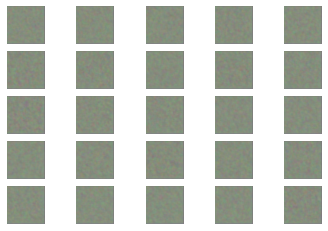

1/1 [==============================] - 0s 207ms/step
1 [D loss: 0.5202926695346832, acc.: 100.0] [G loss: 0.5967189073562622]
1/1 [==============================] - 0s 190ms/step
2 [D loss: 0.372819684445858, acc.: 100.0] [G loss: 0.5328065156936646]
1/1 [==============================] - 0s 191ms/step
3 [D loss: 0.23643915355205536, acc.: 100.0] [G loss: 0.4563407003879547]
1/1 [==============================] - 0s 184ms/step
4 [D loss: 0.12142816744744778, acc.: 100.0] [G loss: 0.3418670892715454]
1/1 [==============================] - 0s 209ms/step
5 [D loss: 0.04804105497896671, acc.: 100.0] [G loss: 0.22172535955905914]
1/1 [==============================] - 0s 195ms/step
6 [D loss: 0.02023327350616455, acc.: 100.0] [G loss: 0.1472882330417633]
1/1 [==============================] - 0s 193ms/step
7 [D loss: 0.010129217524081469, acc.: 100.0] [G loss: 0.09725084900856018]
1/1 [==============================] - 0s 191ms/step
8 [D loss: 0.006223780219443142, acc.: 100.0] [G loss: 0.0

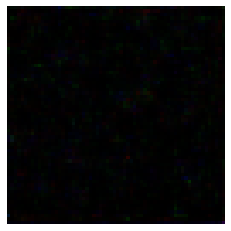

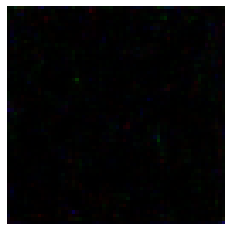

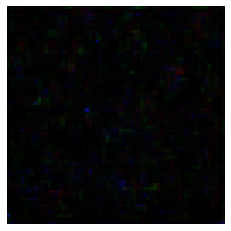

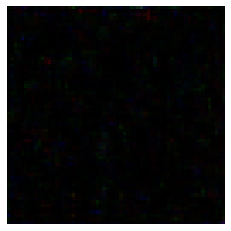

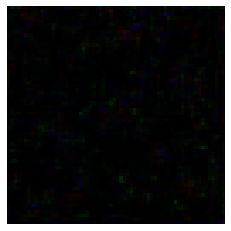

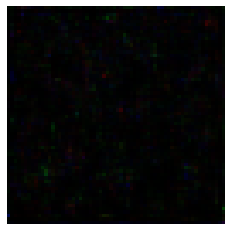

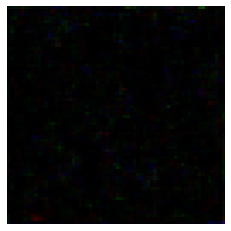

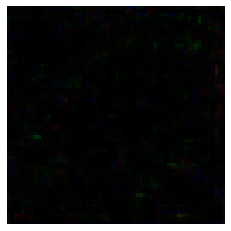

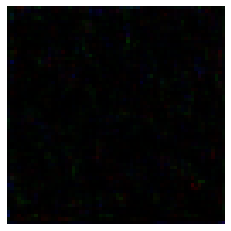

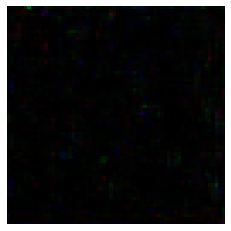

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits

# Step 2: Load and Preprocess Dataset
def load_fits_images_from_folder(folder, image_size=(64, 64)):
    images = []
    files = os.listdir(folder)
    print(f"Found {len(files)} files in the folder.")
    for filename in files:
        if filename.endswith('.fit') or filename.endswith('.fits'):
            file_path = os.path.join(folder, filename)
            try:
                with fits.open(file_path) as hdul:
                    img_data = hdul[0].data
                    if img_data is not None:
                        print(f"File {filename} has data with shape {img_data.shape}")
                        if len(img_data.shape) == 2:  # Ensure the data is 2D
                            img_data = np.nan_to_num(img_data)  # Replace NaNs with 0
                            img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))  # Normalize to [0, 1]
                            img_data = tf.image.resize(img_data[..., np.newaxis], image_size).numpy()  # Resize image
                            img_data = np.repeat(img_data, 3, axis=-1)  # Convert to 3 channels
                            images.append(img_data)
                        else:
                            print(f"Skipping file {filename}, as it does not contain 2D image data.")
                    else:
                        print(f"Skipping file {filename}, as it contains no data.")
            except Exception as e:
                print(f"Skipping file {filename}, as it could not be processed: {e}")
    return np.array(images)

dataset = load_fits_images_from_folder('./Data/fits2_ext')
print(f"Loaded {len(dataset)} images")
if dataset.size == 0:
    raise ValueError("No valid images found in the dataset. Please check the FITS files.")
dataset = (dataset - 0.5) / 0.5  # Normalize to [-1, 1]

# Step 3: Build the GAN

# Generator
def build_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128 * 16 * 16, activation="relu", input_dim=100))
    model.add(tf.keras.layers.Reshape((16, 16, 128)))
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128, kernel_size=4, padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(64, kernel_size=4, padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Conv2D(3, kernel_size=4, padding="same"))
    model.add(tf.keras.layers.Activation("tanh"))
    return model

# Discriminator
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, input_shape=(64, 64, 3), padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates images
z = tf.keras.layers.Input(shape=(100,))
img = generator(z)

# For the combined model, only the generator is trained
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model (stacked generator and discriminator)
combined = tf.keras.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

# Step 4: Train the GAN

# Training parameters
epochs = 100
batch_size = 64
save_interval = 1000

# Load and preprocess the dataset
X_train = dataset
half_batch = int(batch_size / 2)

# Training the GAN
for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.array([1] * batch_size)

    g_loss = combined.train_on_batch(noise, valid_y)

    print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")

    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
        noise = np.random.normal(0, 1, (25, 100))
        gen_imgs = generator.predict(noise)

        gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images 0 - 1

        fig, axs = plt.subplots(5, 5)
        cnt = 0
        for i in range(5):
            for j in range(5):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].axis('off')
                cnt += 1
        plt.savefig(f"generated_images_epoch_{epoch}.png")
        plt.show()

        # Save model weights
        generator.save_weights('generator_weights.h5')
        discriminator.save_weights('discriminator_weights.h5')

# Step 5: Generate New Data

noise = np.random.normal(0, 1, (10, 100))
gen_imgs = generator.predict(noise)
gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images 0 - 1

for i in range(10):
    plt.imshow(gen_imgs[i])
    plt.axis('off')
    plt.show()
